# Initializing config, dataset and the oracle

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import Config, Dataset
from oracle import Oracle
from active_learning import Learner

config = Config(70, 10)
data = Dataset(config)
orac_lc = Oracle(data, config)
orac_ms = Oracle(data, config)
orac_h = Oracle(data, config)

# Visualizing the digit dataset after PCA

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=2)
decomposed_digit = pca.fit_transform(X = data.x_raw)

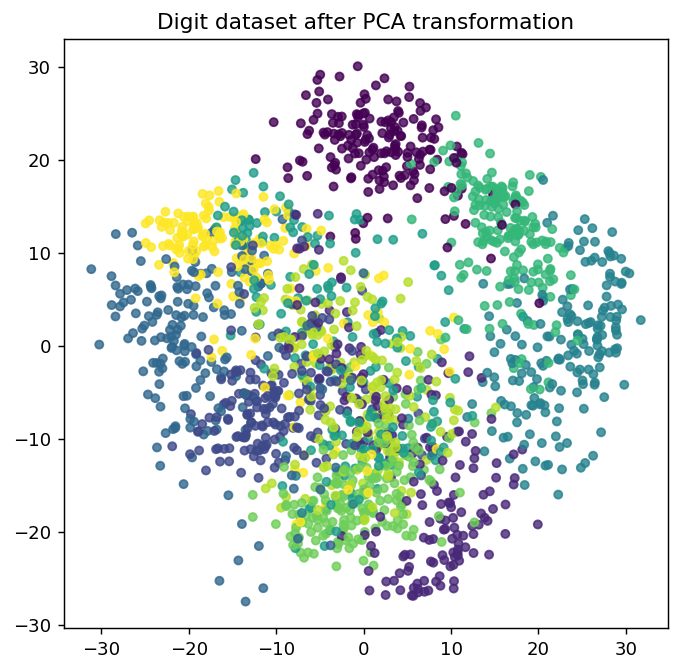

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = decomposed_digit[:, 0], decomposed_digit[:, 1]

test_c1, test_c2 = [], []
for i in range(len(data.test_indices)):
    test_c1.append(x_component[data.test_indices[i]])
    test_c2.append(y_component[data.test_indices[i]])

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(6, 6), dpi=130)
plt.scatter(x = x_component, y = y_component, c = data.y_raw, cmap = 'viridis', s = 20, alpha = 8/10)
plt.title('Digit dataset after PCA transformation')
plt.show()

# Instantiating a Learner instance

In [5]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, probability=True)

least_count_learner = Learner([clf], "uncertainty", uncertainty = "lc")
margin_sampling_learner = Learner([clf], "uncertainty", uncertainty = "ms")
entropy_learner = Learner([clf], "uncertainty", uncertainty = "entropy")

# Initial training for the active learners

In [6]:
least_count_learner.train(orac_lc)
margin_sampling_learner.train(orac_ms)
entropy_learner.train(orac_h)

In [7]:
initial_pred_lc = least_count_learner.predict(data.test_X)
initial_pred_ms = margin_sampling_learner.predict(data.test_X)
initial_pred_h = entropy_learner.predict(data.test_X)

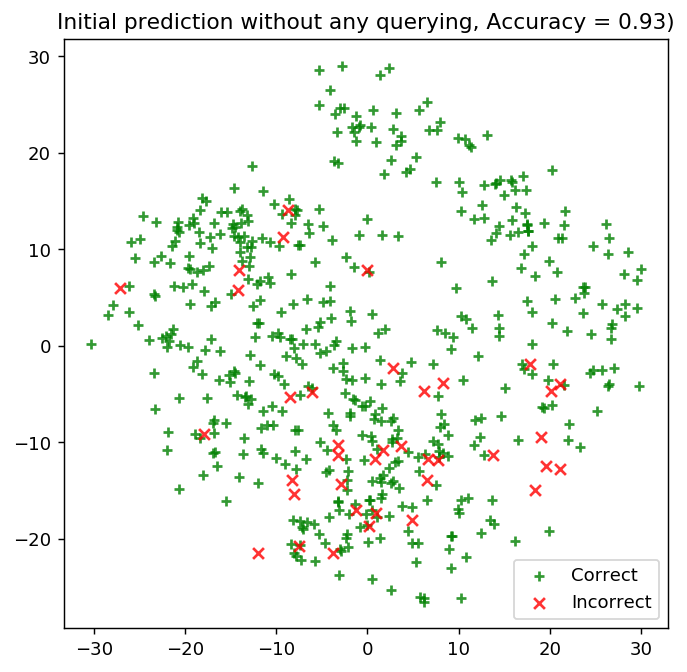

In [8]:
import numpy as np

is_correct = (initial_pred_lc == np.array(data.test_Y))

fig, ax1 = plt.subplots(figsize=(6, 6), dpi=130)
fig.suptitle = "Initial prediction without any querying"

ax1.scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax1.scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax1.legend(loc='lower right')
ax1.set_title("Initial prediction without any querying, Accuracy = {score:.2f})".format(score=least_count_learner.test_score(data)))

plt.show()

# Querying

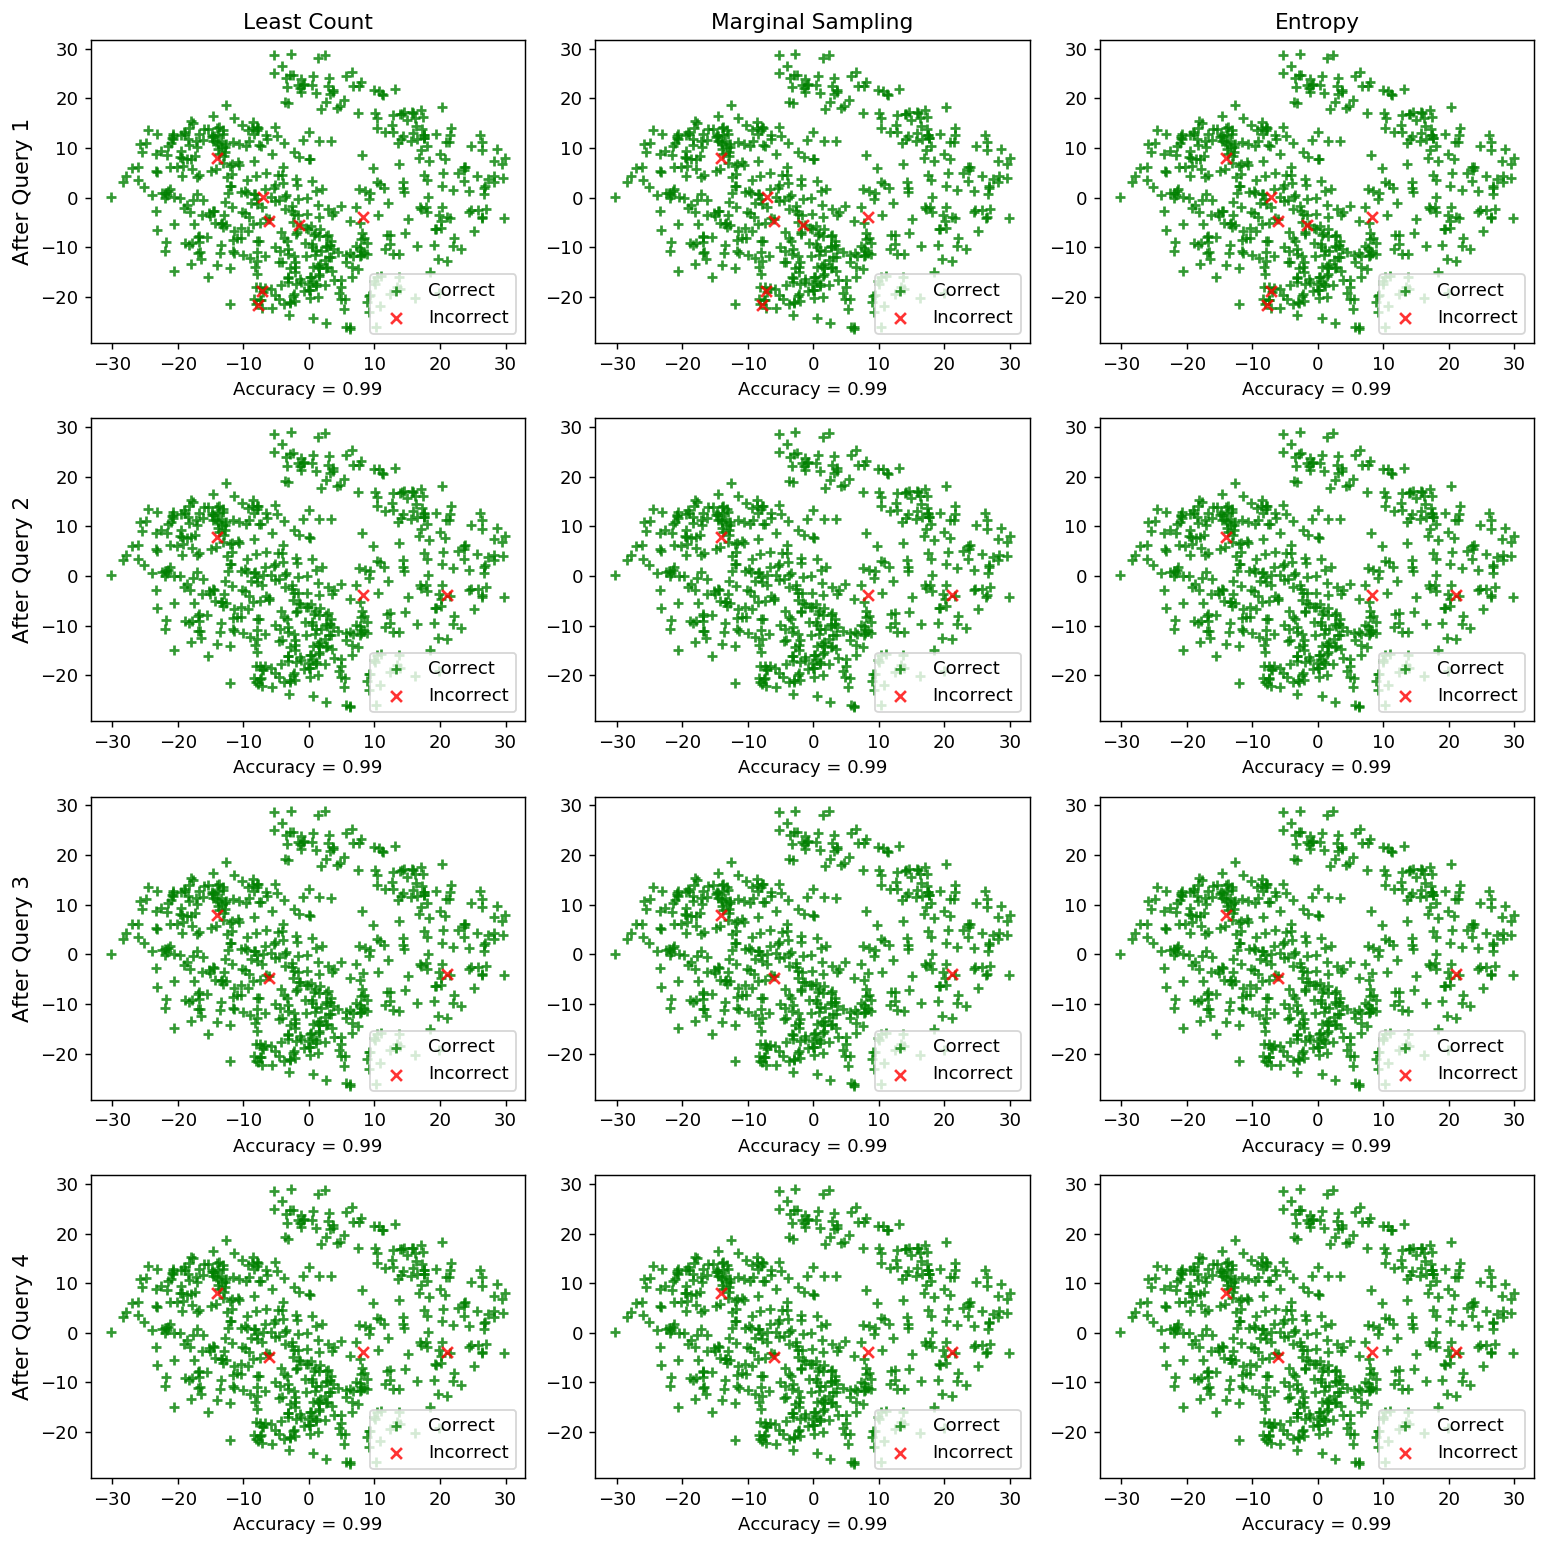

In [9]:
''' 4 consecutive queries for labelling 10% data in each iteration and evaluating the test performance for 
all the possible informativeness metrics
'''
unqueried_score = least_count_learner.test_score(data)
performance_lc = [unqueried_score]
performance_ms = [unqueried_score]
performance_h = [unqueried_score]

fig, axs = plt.subplots(4, 3, figsize=(12, 12), dpi = 130)

cols = ['Least Count', 'Marginal Sampling', 'Entropy']
rows = ['After Query {}'.format(row) for row in ['1', '2', '3', '4']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

for i in range(1, 5):
    # query for additional 10% of the data using the 3 informativeness metrics
    least_count_learner.query(data, orac_lc)
    margin_sampling_learner.query(data, orac_ms)
    entropy_learner.query(data, orac_h)
        
    # training the model after obtaining the labels
    least_count_learner.train(orac_lc)
    margin_sampling_learner.train(orac_ms)
    entropy_learner.train(orac_h)
    
    # predictions after retraining
    pred_lc = least_count_learner.predict(data.test_X)
    pred_ms = margin_sampling_learner.predict(data.test_X)
    pred_h = entropy_learner.predict(data.test_X)
    
    # analysis of least count informativeness
    is_correct = (pred_lc == np.array(data.test_Y))
    
    axs[i-1][0].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10) 
    axs[i-1][0].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
    axs[i-1][0].legend(loc='lower right')
    axs[i-1][0].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=least_count_learner.test_score(data)))
    
    performance_lc.append(least_count_learner.test_score(data))
    
    # analysis of margin sample informativeness
    is_correct = (pred_ms == np.array(data.test_Y))
    
    axs[i-1][1].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10) 
    axs[i-1][1].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
    axs[i-1][1].legend(loc='lower right')
    axs[i-1][1].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=margin_sampling_learner.test_score(data)))

    performance_ms.append(margin_sampling_learner.test_score(data))
    
    # analysis of entropy informativeness
    is_correct = (pred_h == np.array(data.test_Y))
    
    axs[i-1][2].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10) 
    axs[i-1][2].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
    axs[i-1][2].legend(loc='lower right')
    axs[i-1][2].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=entropy_learner.test_score(data)))    
    
    performance_h.append(entropy_learner.test_score(data))
    
fig.tight_layout()    
plt.show()


In [12]:
performance_lc

[0.9296296296296296,
 0.987037037037037,
 0.9944444444444445,
 0.9944444444444445,
 0.9925925925925926]

# Plotting Improvements with successive querying

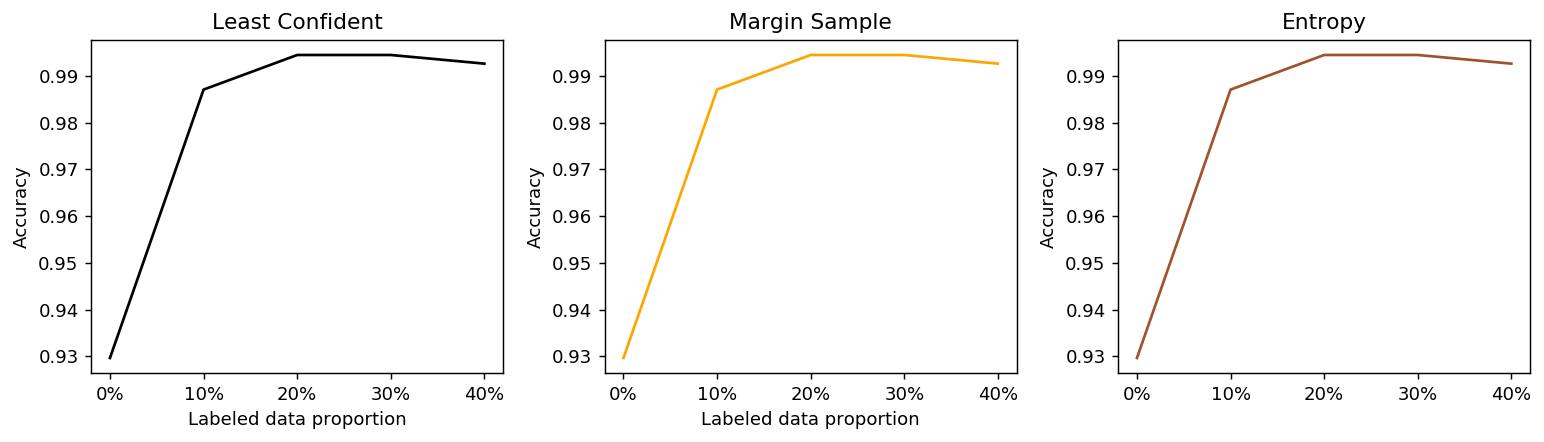

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), dpi = 130)

cols = ['Least Count', 'Marginal Sampling', 'Entropy']

label_proportion = ['0%', '10%', '20%', '30%', '40%']
axs[0].plot(label_proportion, performance_lc, label = "Least Count", color='black')
axs[1].plot(label_proportion, performance_ms, label = "Margin Sample", color='orange')
axs[2].plot(label_proportion, performance_ms, label = "Entropy", color='sienna')

axs[0].set_title('Least Confident')
axs[1].set_title('Margin Sample')
axs[2].set_title('Entropy')

axs[0].set_xlabel('Labeled data proportion')
axs[1].set_xlabel('Labeled data proportion')
axs[0].set_xlabel('Labeled data proportion')

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[2].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()